### Feature extraction

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
import os
from skimage.io import imread, imshow

def get_paths(directory):
    '''
    Devuelve la ruta relativa de las muestras .bmp
    '''
    paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".bmp"):
                paths.append(os.path.join(root, file))
    return paths

In [77]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16 as vgg16_preprocessor
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.applications import MobileNetV2
import numpy as np
import cv2

model = VGG16(weights='imagenet') #include_top=False
model = Model(model.input, model.layers[-2].output)
# model.summary()

img_paths = get_paths("CASIA-Polar")
images = [cv2.resize(cv2.imread(muestra),(224,224))  for muestra in img_paths] # en blanco y negro
features = []

for img in images[:2]:
#     print(path)
#     img = image.load_img(path, target_size=(224, 224))
# for img in resized[:2]:
#     print(path)
    img_data = image.img_to_array(img)
    print(img_data.shape)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    print(vgg16_feature.shape)
    features.append(vgg16_feature)
print("DONE!")

(224, 224, 3)
(1, 4096)
(224, 224, 3)
(1, 4096)
DONE!


In [62]:
features[0][0].shape, features[0][0][:10]

((4096,), array([0.        , 0.        , 0.        , 1.51282   , 0.        ,
        0.        , 3.1035907 , 0.        , 0.16785401, 0.        ],
       dtype=float32))

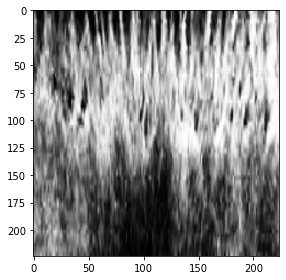

In [63]:
imshow(resized[0]);

--------------------------------

---------------------

In [88]:
# train_val_test = "CASIA-Classification"
# if os.path.exists(train_val_test):
#     shutil.rmtree(train_val_test)
# # os.mkdir(train_val_test)

In [66]:
# # directorio de entrenamiento
# train_dir = os.path.join(train_val_test, 'train')
# os.mkdir(train_dir)

# # directorio de validación
# val_dir = os.path.join(train_val_test, 'validation')
# os.mkdir(val_dir)

# # directorio de testeo
# test_dir = os.path.join(train_val_test, 'test')
# os.mkdir(test_dir)

In [72]:
# names = os.listdir("CASIA-Polar")
# # creamos los directorios con los nombres de los sujetos
# for n in names:
#     os.mkdir(os.path.join(train_dir,n))
#     os.mkdir(os.path.join(val_dir,n))
#     os.mkdir(os.path.join(test_dir,n))

Si fuese un problema de clasificación binaria únicamente habrían 2 clases, pero al tratarse de clasificación multiclase se necesitan más de 2 clases que en este caso se corresponden con el número de sujetos que tenemos en nuestra base de datos.

In [75]:
# sujetos = len(os.listdir(train_dir)) # nro de clases/sujetos
# # da igual listar el directorio de train, val o test, ya que los 3 tienen el mismo número de sujetos
# sujetos

108

Cada sujeto tiene 7 muestras, por lo que se destinarán 3 de esas muestras para el entrenamiento, 2 para validación y finalmente las 2 restantes para testear.

In [90]:
! pip install split-folders tqdm

In [101]:
# shutil.rmtree("CASIA-Classification")

In [102]:
import splitfolders
# https://pypi.org/project/split-folders/
# módulo que hace más fácil dividir el dataset en train/val/dir
splitfolders.fixed("CASIA-Polar", output="CASIA-Classification", seed=1337, fixed=(2,2),group_prefix=None) # default values

Copying files: 756 files [00:00, 812.46 files/s]


In [103]:
train_dir = "CASIA-Classification" + os.sep + "train"
val_dir = "CASIA-Classification" + os.sep + "val" 
test_dir = "CASIA-Classification" + os.sep + "test"

In [107]:
print('Muestras de entrenamiento totales:', len(os.listdir(train_dir))*3) # *3 muestras por sujeto 
print('Muestras de validación totales:', len(os.listdir(val_dir))*2) # *2 muestras por sujeto
print('Muestras de testeo totales:', len(os.listdir(test_dir))*2)  # *2 muestras por sujeto

Muestras de entrenamiento totales: 324
Muestras de validación totales: 216
Muestras de testeo totales: 216


In [104]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16

In [108]:
img_width, img_height = 224, 224  # Default input size for VGG16

# modelo
conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3)) # imput for VGG16 -> (224, 224, 3)
# Show architecture
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [110]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,108)) # 108 classes
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 324)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(val_dir, 216)
# test_features, test_labels = extract_features(test_dir, test_size)

Found 324 images belonging to 108 classes.
Found 216 images belonging to 108 classes.


In [114]:
len(train_labels), len(validation_labels)

(324, 216)

In [116]:
epochs = 150

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(108, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 108)               55404     
Total params: 55,404
Trainable params: 55,404
Non-trainable params: 0
_________________________________________________________________


In [118]:
# compilamos modelo
model.compile(loss='categorical_crossentropy',
             optimizer='adam', # probar con otro optimizador y comparar
             metrics=['accuracy'])

In [121]:
# from keras.callbacks.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
#                     callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))

Epoch 1/150
11/11 [==============================] - 0s 17ms/step - loss: 4.8838 - accuracy: 0.0093 - val_loss: 4.7663 - val_accuracy: 0.0093
Epoch 2/150
11/11 [==============================] - 0s 7ms/step - loss: 4.7463 - accuracy: 0.0093 - val_loss: 4.6895 - val_accuracy: 0.0185
Epoch 3/150
11/11 [==============================] - 0s 7ms/step - loss: 4.6796 - accuracy: 0.0123 - val_loss: 4.6401 - val_accuracy: 0.0093
Epoch 4/150
11/11 [==============================] - 0s 7ms/step - loss: 4.6293 - accuracy: 0.0123 - val_loss: 4.6110 - val_accuracy: 0.0231
Epoch 5/150
11/11 [==============================] - 0s 7ms/step - loss: 4.5942 - accuracy: 0.0278 - val_loss: 4.5859 - val_accuracy: 0.0278
Epoch 6/150
11/11 [==============================] - 0s 8ms/step - loss: 4.5646 - accuracy: 0.0309 - val_loss: 4.5634 - val_accuracy: 0.0278
Epoch 7/150
11/11 [==============================] - 0s 8ms/step - loss: 4.5379 - accuracy: 0.0525 - val_loss: 4.5434 - val_accuracy: 0.0509
Epoch 8/150


In [122]:
model.save('VGG16_v1.h5') # guardamos modelo

In [123]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

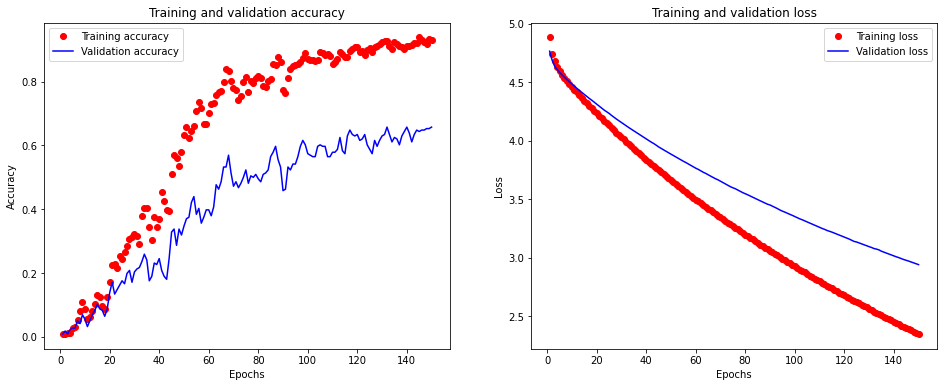

In [217]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc)+1)


fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(16,6))
ax0.plot(epochs, acc, 'bo', label='Training accuracy', color='r')
ax0.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax0.set(
    title='Training and validation accuracy',
    xlabel='Epochs',
    ylabel='Accuracy')
ax0.legend()

ax1.plot(epochs, loss, 'bo', label='Training loss', color='r')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set(
    title='Training and validation loss',
    xlabel='Epochs',
    ylabel='Loss')
ax1.legend()

plt.show()

In [218]:
from keras.preprocessing import image
def prediction(img_path, classes_names):
    cv2.resize(cv2.imread(img_path),(224,224))
    org_img = cv2.imread(img_path)
#     img = image.load_img(img_path, target_size=(img_width, img_height))
    img = cv2.resize(cv2.imread(img_path),(224,224))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 7*7*512))
        
    classes = classes_names
    print("Sujeto identificado: "+str(classes[np.argmax(np.array(prediction[0]))]))

In [128]:
test_dir

'CASIA-Classification\\test'

In [214]:
import random
sujetos = []
for root, dirs, files in os.walk(test_dir):
    for f in files:
        sujetos.append(os.path.join(root, f))
#         print(os.path.join(root, f))
pred_files = random.sample(sujetos, 10)
pred_files

['CASIA-Classification\\test\\Brianny\\Brianny_7.bmp',
 'CASIA-Classification\\test\\Ashton\\Ashton_5.bmp',
 'CASIA-Classification\\test\\Leibish\\Leibish_7.bmp',
 'CASIA-Classification\\test\\Hersh\\Hersh_5.bmp',
 'CASIA-Classification\\test\\Naomi\\Naomi_5.bmp',
 'CASIA-Classification\\test\\Janiyah\\Janiyah_7.bmp',
 'CASIA-Classification\\test\\Margot\\Margot_7.bmp',
 'CASIA-Classification\\test\\Cooper\\Cooper_5.bmp',
 'CASIA-Classification\\test\\Avital\\Avital_5.bmp',
 'CASIA-Classification\\test\\Carlos\\Carlos_5.bmp']

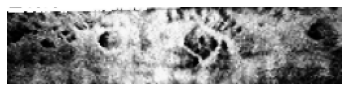

Sujeto identificado: Zaiden


In [219]:
prediction(pred_files[0],names);

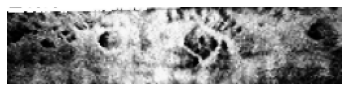

Sujeto identificado: Zaiden


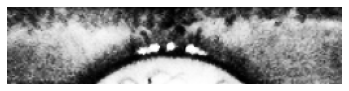

Sujeto identificado: Erick


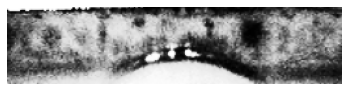

Sujeto identificado: Delilah


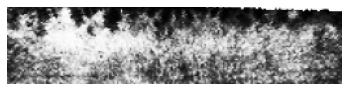

Sujeto identificado: Frimet


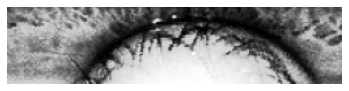

Sujeto identificado: Rohan


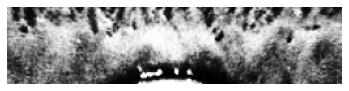

Sujeto identificado: Zaiden


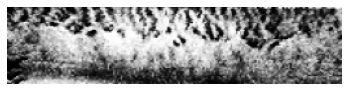

Sujeto identificado: Eddy


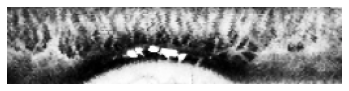

Sujeto identificado: Delilah


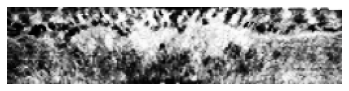

Sujeto identificado: Avital


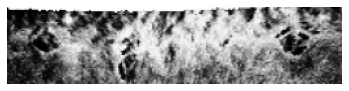

Sujeto identificado: Alice


In [220]:
for img_path in pred_files:
    prediction(img_path, names)

In [193]:
from keras.models import load_model

modelV1 = load_model('VGG16_v1.h5')
modelV1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 108)               55404     
Total params: 55,404
Trainable params: 55,404
Non-trainable params: 0
_________________________________________________________________


In [205]:
test_features, test_labels = extract_features(test_dir, 216)

Found 216 images belonging to 108 classes.


In [206]:
# test_generator = datagen.flow_from_directory(test_dir,
#                                             target_size=(img_width,img_height),
#                                             batch_size = batch_size,
#                                             class_mode='categorical')

test_loss, test_acc = modelV1.evaluate(test_features, test_labels, verbose=1)

7/7 [==============================] - 0s 2ms/step - loss: 2.9991 - accuracy: 0.6435


In [207]:
test_acc

0.6435185074806213